# missdat: A Python Package for Comprehensive Missing Data Diagnostics and Estimation

Below is a comprehensive document that expands on the theoretical foundations and workings of each core function in the `missdat` package. It includes the relevant equations and justifications for key methodological choices.
___

## Introduction

Effective handling of missing data is crucial for drawing valid inferences in statistical analysis and machine learning. Missing values, if not appropriately handled, can introduce bias, reduce statistical power, and compromise the reliability of conclusions (Little & Rubin, 2002). The `missdat` package provides a robust suite of tools for diagnosing, testing, and addressing missing data in datasets. It integrates:

- **Missing Data Diagnostics:** Tools to explore and quantify missingness patterns.
- **Statistical Testing for Missing Completely at Random (MCAR):** Parametric and non-parametric methods to determine if missing data are random.
- **Imputation via Expectation-Maximization (EM) under Full Information Maximum Likelihood (FIML):** A principled likelihood-based approach to estimate missing values.

This document details the theoretical underpinnings, relevant equations, and justifications for each function in the package, as well as their role within a comprehensive missing data handling pipeline.

We will first start with simulating data to be used to demonstrate each function. Each function, its procedure and theory will be outlined followed by an example of each function.
---

### Simulating example dataframe

In [6]:
# Package downloading
import sys
from IPython.utils import io
if 'google.colab' in sys.modules:

  with io.capture_output() as captured:
      !pip install missdat watermark

import pandas as pd
import numpy as np
import scipy
from scipy import stats
import missdat as ms # for missing data diagnostics
from matplotlib import pyplot as plt
import seaborn as sns


## simulating data
np.random.seed(42)
data_sim = pd.DataFrame({
    "A": np.random.randn(100),
    "B": np.random.randn(100),
    "C": np.random.randn(100)
})

# Introduce missing values
data_sim.loc[np.random.choice(100, 10, replace=False), "A"] = np.nan
data_sim.loc[np.random.choice(100, 15, replace=False), "B"] = np.nan
data_sim.loc[np.random.choice(100, 20, replace=False), "C"] = np.nan

pd.DataFrame(np.sum(np.isnan(data_sim),axis=0), columns = ["n missing"]).T


,A,B,C
n missing,10,15,20


## 1. Missing Data Diagnostics


### 1.1 The `miss_ind()` Function

---

#### **Purpose**
The `miss_ind()` function creates a binary indicator for each row in the dataset, flagging whether a row contains any missing values.  

#### **Procedure and Equations**
For each row $ i $ in the DataFrame:
- Define the indicator function:
  $
  I_i = \begin{cases}
  1 & \text{if } \exists\, j \text{ such that } X_{ij} \text{ is missing}, \\
  0 & \text{otherwise.}
  \end{cases}
  $
- The function iterates over each row and checks for the presence of any `NaN` values, then creates a new DataFrame column `"missing_indicator"` with these values.

#### **Justification**
- **Binary Simplification:** Using a binary indicator simplifies the assessment of overall missingness at the observation level.
- **Exploratory Analysis:** This approach allows researchers to quickly identify if missingness is concentrated in specific observations, which may indicate data quality issues or non-random missingness patterns.


In [25]:
ms.miss_ind(data_sim)

,missing_indicator
0,0
1,0
2,0
3,1
4,0
...,...
95,0
96,0
97,0
98,0


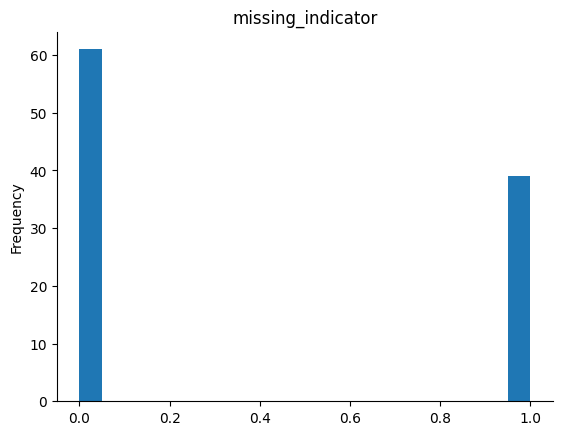

In [20]:
_df_0 = ms.miss_ind(data_sim)
_df_0['missing_indicator'].plot(kind='hist', bins=20, title='missing_indicator')
plt.gca().spines[['top', 'right',]].set_visible(False)

### 1.2. Missing Data Diagnostics with `missing_diagnostics()`



___
### **Purpose**

The `missing_diagnostics()` function (if implemented) would provide a holistic overview of the missingness in the dataset—identifying patterns, proportions of missing data per variable, and possible associations among missingness across different columns.

#### Theoretical Foundation

- **Quantification of Missingness:**  
  Often, missingness is summarized by calculating the proportion of missing entries per variable:
  
  $
  p_j = \frac{1}{n}\sum_{i=1}^{n} \mathbf{1}(X_{ij} \text{ is missing})
  $
  
  where $ n $ is the total number of observations.

- **Association Measures:**  
  To understand the dependence structure between missingness in different variables, statistical measures such as correlations or cross-tabulations can be used.

#### Justification

- **Pattern Recognition:**  
  Recognizing systematic patterns (e.g., block missingness or monotonic missingness) informs subsequent imputation strategies, as certain patterns may suggest underlying mechanisms or data collection issues.

- **Visual Diagnostics:**  
  Outputs from this function can easily be imported into plotting software functoins for visualization.


### Example

In [9]:
miss_df, cor_df, all_stats, pat_df, item_df = ms.miss_diagnostics(data_sim)

#### **Missing data pattens for each row**
___

In [10]:
miss_df

,A,B,C
0,0,0,0
1,0,0,0
2,0,0,0
3,0,1,0
4,0,0,0
...,...,...,...
95,0,0,0
96,0,0,0
97,0,0,0
98,0,0,0


##### Figure showing individual level missing statistics

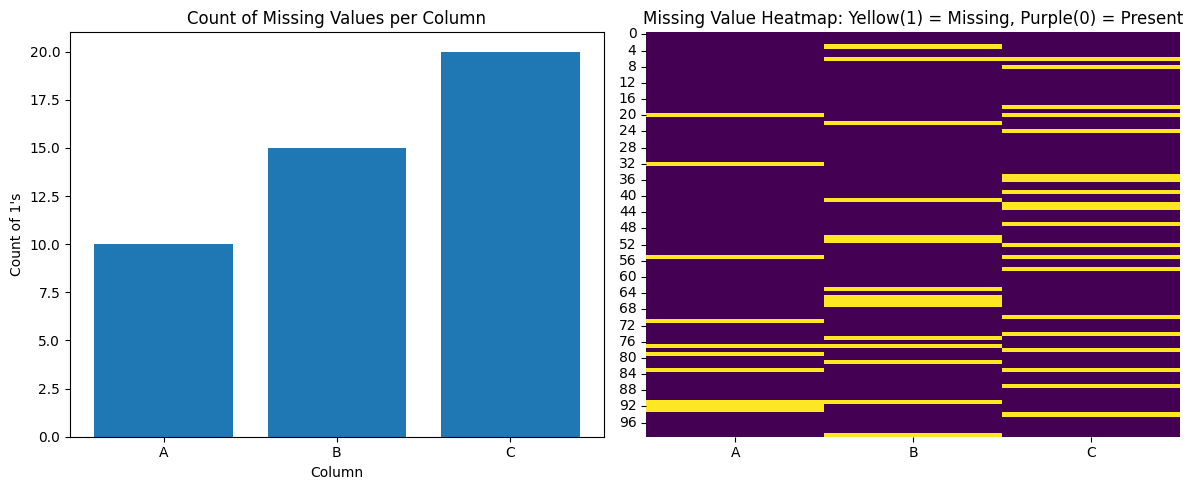

In [11]:
# Calculate the count of 1's for each column
missing_counts = miss_df.apply(lambda x: (x == 1).sum())

# Create a figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the count of 1's
axes[0].bar(missing_counts.index, missing_counts.values)
axes[0].set_xlabel("Column")
axes[0].set_ylabel("Count of 1's")
axes[0].set_title("Count of Missing Values per Column")


# Create the heatmap
sns.heatmap(miss_df, annot=False, cmap='viridis', ax=axes[1], cbar=False) #cbar=False removes color bar
axes[1].set_title("Missing Value Heatmap: Yellow(1) = Missing, Purple(0) = Present")

# Adjust layout and display
plt.tight_layout()
plt.show()


#### **Strength of association between missing patterns**
___

In [12]:
cor_df

,A,B,C
A,1.000000,0.046676,0.083333
B,0.046676,1.000000,-0.140028
C,0.083333,-0.140028,1.000000


##### Figure of associations between missing patterns

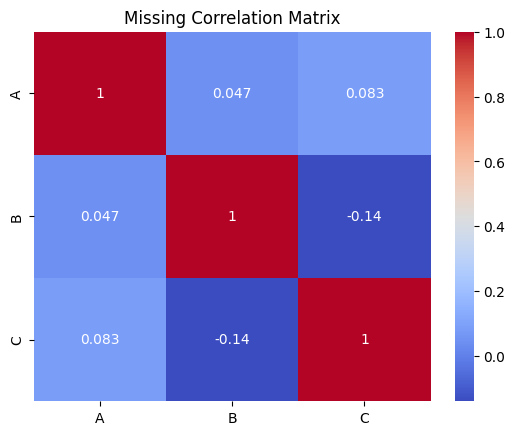

In [13]:
sns.heatmap(cor_df, annot=True, cmap='coolwarm')
plt.title('Missing Correlation Matrix')
plt.show()

#### **Overal missing statistics**
___

In [14]:
all_stats

,overall missing stats
missing_patterns,7.00
proportion_missing,0.15
proportion_complete,0.85


#### **Common patterns of missing data**
___

In [15]:
pat_df

,A,B,C,n
Missing Pattern 1,0,0,0,61
Missing Pattern 2,0,0,1,16
Missing Pattern 3,0,1,0,12
Missing Pattern 4,0,1,1,1
Missing Pattern 5,1,0,0,5
Missing Pattern 6,1,0,1,3
Missing Pattern 7,1,1,0,2


##### Figure depicting missing data pattenrs

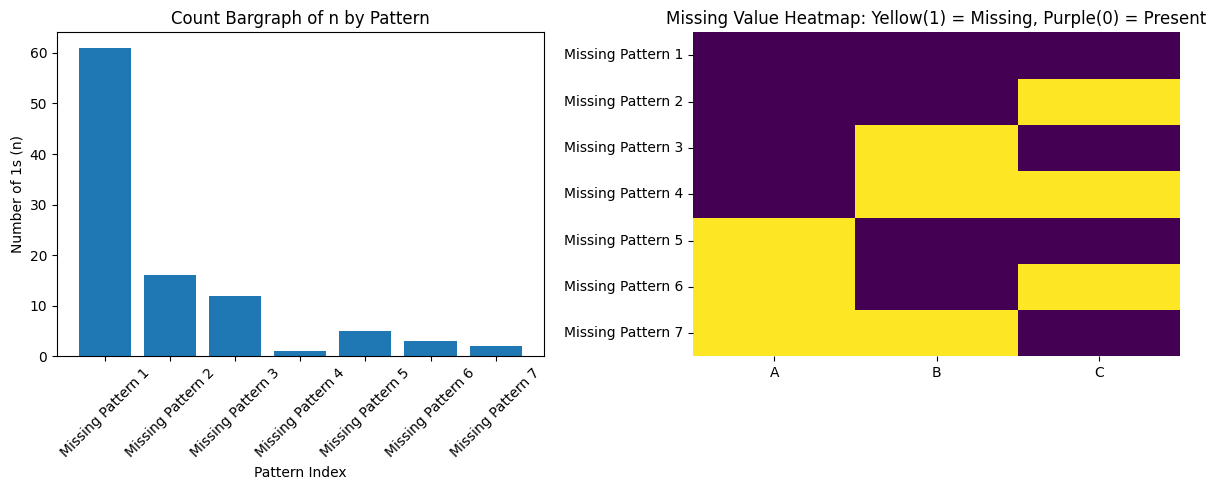

In [16]:
# Calculate the count of 1's in the 'n' column
missing_counts = pat_df['n'].value_counts()

# Create a DataFrame for the heatmap
miss_df = pat_df[['A', 'B', 'C']]


# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the count of missing
axes[0].bar(pat_df.index, pat_df['n'])
axes[0].set_xlabel('Pattern Index')
axes[0].set_ylabel('Number of 1s (n)')
axes[0].set_title('Count Bargraph of n by Pattern')
axes[0].set_xticks(pat_df.index)
axes[0].tick_params(axis='x', rotation=45)

# Create the heatmap
sns.heatmap(miss_df, annot=False, cmap='viridis', ax=axes[1], cbar=False)
axes[1].set_title("Missing Value Heatmap: Yellow(1) = Missing, Purple(0) = Present")

# Adjust layout and display
plt.tight_layout()
plt.show()


#### **Item level statistics**
___

In [17]:
item_df

,number_missing,proportion_missing,proportion_complete
A,10,0.10,0.90
B,15,0.15,0.85
C,20,0.20,0.80


##### Figure depicting item level missing patterns

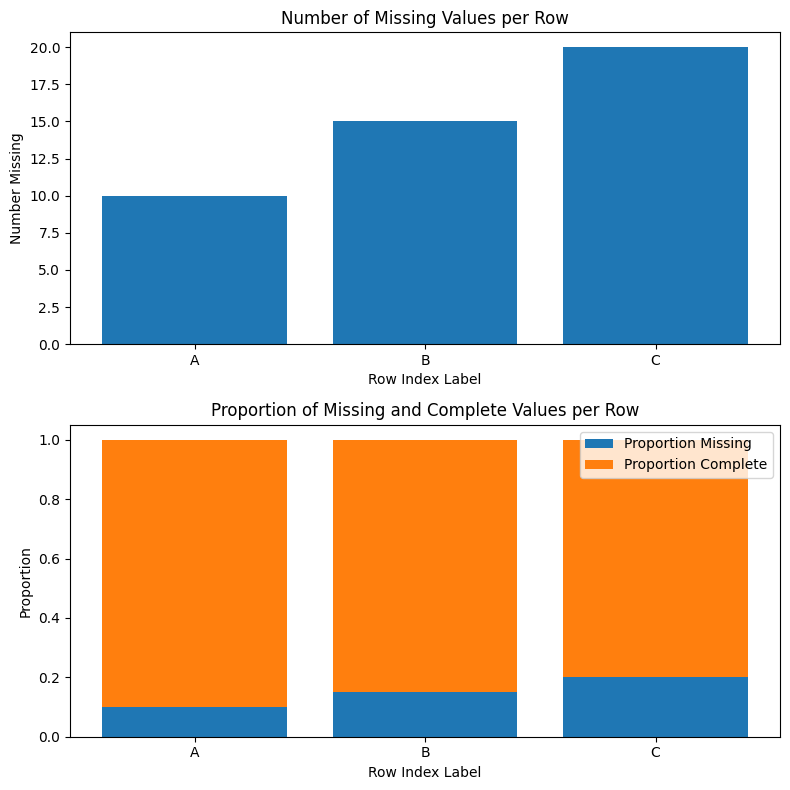

In [18]:
# Create the first bar graph (number missing)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))  # Adjust figsize as needed


axes[0].bar(item_df.index, item_df['number_missing'])
axes[0].set_xlabel("Row Index Label")
axes[0].set_ylabel("Number Missing")
axes[0].set_title("Number of Missing Values per Row")

# Create the second stacked bar graph (proportion missing and complete)
axes[1].bar(item_df.index, item_df['proportion_missing'], label='Proportion Missing')
axes[1].bar(item_df.index, item_df['proportion_complete'], bottom=item_df['proportion_missing'], label='Proportion Complete')
axes[1].set_xlabel("Row Index Label")
axes[1].set_ylabel("Proportion")
axes[1].set_title("Proportion of Missing and Complete Values per Row")
axes[1].legend()


plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

## 2. Testing for MCAR with `mcar_test()` and `mcar_test_np()`

### 2.1 Parametric MCAR Test (`mcar_test()`)

___

#### Basis
The parametric MCAR test implemented in `mcar_test()` is typically based on Little’s MCAR test. Little’s test evaluates the null hypothesis that the missing data occur completely at random (MCAR), meaning that the probability of an observation being missing does not depend on either the observed or unobserved data.

#### Procedure

1. **Identify Missing Patterns:**  
   - The dataset is divided into groups (or patterns) based on the configuration of missing and observed values.
   
2. **Group-wise Mean Estimation:**  
   - For each pattern, the means of the observed variables are computed.  
   - Let $ \mu_{j}^{(p)} $ denote the mean of variable $ j $ in missing pattern $ p $.

3. **Compute Overall Mean Differences:**  
   - The test compares the means estimated from each pattern to the overall mean across all patterns.
   - The differences between group-specific means and the overall mean reflect how much the missingness pattern is associated with the data values.

4. **Derive Test Statistic:**  
   - The test statistic is constructed by summing weighted squared differences between the pattern-specific means and the overall means.  
   - In practice, the statistic is often defined as:
     $
     T = \sum_{p=1}^{P} n_p (\mu^{(p)} - \mu)^T \Sigma^{-1} (\mu^{(p)} - \mu)
     $
     
     where:
     - $ P $ is the number of distinct missingness patterns,
     - $ n_p $ is the number of observations in pattern $ p $,
     - $ \mu^{(p)} $ is the vector of means for pattern $ p $,
     - $ \mu $ is the overall mean vector,
     - $ \Sigma $ is the covariance matrix of the observed data.
     
5. **Statistical Inference:**  
   - Under the null hypothesis of MCAR, the test statistic $ T $ approximately follows a chi-square distribution with degrees of freedom determined by the number of patterns and the number of variables.
   - A p-value is computed using chi-square approximations:
     $
     p\text{-value} = P\left( \chi^2_{\nu} \geq T \right)
     $
     where $ \nu $ represents the appropriate degrees of freedom.

#### Equations

- **Group-specific Difference:**  
  For each missing pattern $ p $:
  $
  d^{(p)} = \mu^{(p)} - \mu
  $
- **Test Statistic:**  
  The overall test statistic is given by:
  $
  T = \sum_{p=1}^{P} n_p \, \left( d^{(p)} \right)^T \, \Sigma^{-1} \, d^{(p)}
  $
- **P-value Calculation:**  
  Under $ H_0 $ (MCAR), $ T \sim \chi^2_{\nu} $ and the p-value is:
  $
  p\text{-value} = P\left( \chi^2_{\nu} \geq T \right)
  $

*(Note: The specific form of $( T )$ may vary with implementation details and the method used for partitioning the data by missingness pattern.)*

#### Justification

- **Theoretical Rationale:**  
  Little’s MCAR test is grounded in the principle that if missingness is completely random, then the differences between the means of various missing data patterns and the overall mean should be small. Large discrepancies indicate that the likelihood of missingness may depend on the observed values, suggesting that the data are not MCAR.
  
- **Use of Chi-Square Distribution:**  
  By comparing the observed test statistic to a chi-square distribution, the method provides a formal framework for hypothesis testing. The chi-square approximation offers a way to compute p-values and make decisions regarding the MCAR assumption.
  
- **Assumptions and Limitations:**  
  This parametric approach assumes that the underlying data distribution is approximately multivariate normal. When this assumption holds, the test is powerful and reliable. However, if the data significantly deviate from normality, the results may be less trustworthy, and a non-parametric alternative (such as `mcar_test_np()`) may be preferable.

#### Usage

The parametric MCAR test is best suited for datasets that meet the assumption of multivariate normality. It can be integrated into a missing data handling pipeline as follows:

1. **Pre-Imputation Assessment:**  
   Use `mcar_test()` to determine if missing values are likely MCAR.  
   - **If the p-value is high (typically $ p \geq 0.05 $):**  
     The data can be considered MCAR, and simple imputation methods may be appropriate.
   - **If the p-value is low (typically $ p < 0.05 $):**  
     The missingness is likely non-random (MAR or MNAR), suggesting that more sophisticated imputation techniques or modeling adjustments are needed.

2. **Pipeline Decision:**  
   Based on the test results, decide whether to proceed with standard imputation methods or to adjust the analysis strategy to account for the non-random nature of the missing data.

By providing a clear statistical framework and hypothesis testing procedure, `mcar_test()` offers a principled way to evaluate the missing data mechanism, which is a critical step in any missing data handling pipeline.


### Example

In [21]:
ms.mcar_test(data_sim)

,MCAR Test Values
number of missing patterns,7
x2,7.016052
df,17.0
p,0.98334
alpha,0.05
interpretation,Missing Completely at Random (MCAR)



### 2.2 Non-Parametric MCAR Test (`mcar_test_np()`)


___
#### Procedure

1. **Row Means Calculation:**  
   Compute the overall row mean $ R_i $ for each observation (ignoring NaNs):
   $
   R_i = \frac{1}{p_i} \sum_{j \in O_i} X_{ij}
   $
   where $ O_i $ is the set of observed variables for row $ i $ and $ p_i $ is the number of observed values.

2. **Missing Indicator Vector for Each Column:**  
   For column $ j $, define:
   $
   (M_j)_i = \begin{cases}
   1, & \text{if } X_{ij} \text{ is missing} \\
   0, & \text{otherwise}
   \end{cases}
   $

3. **Spearman Correlation:**  
   Compute the Spearman correlation $ \rho_j $ between $ M_j $ and $ R $:
   $
   \rho_j = \text{Spearman}(M_j, R)
   $
   This is computed non-parametrically, capturing monotonic relationships without assuming linearity.

4. **Overall Test Statistic:**  
   Sum the absolute values of these correlations over all columns with missing data:
   $
   T_{\text{obs}} = \sum_{j \in \mathcal{J}} |\rho_j|
   $
   where $ \mathcal{J} $ is the set of columns with missing values.

5. **Permutation Testing:**  
   Permute the missing indicator for each column $ K $ times and recalculate the test statistic for each permutation:
   $
   T^{(k)} = \sum_{j \in \mathcal{J}} |\rho_j^{(k)}|
   $
   The p-value is computed as:
   $
   p = \frac{1}{K} \sum_{k=1}^{K} \mathbf{1}\left( T^{(k)} \geq T_{\text{obs}} \right)
   $

### Justification

- **Spearman Correlation:**  
  Chosen because it is robust to non-normality and outliers, capturing monotonic relationships between missingness and overall data values.
  
- **Permutation Approach:**  
  Generates a null distribution without relying on strong parametric assumptions, providing a rigorous non-parametric hypothesis test.

### Usage in a Pipeline

- **Diagnostic Decision:**  
  Use MCAR tests to decide whether simple imputation methods are appropriate or if the missingness mechanism is non-random (suggesting the need for more advanced imputation or modeling adjustments).


### Example

In [22]:
ms.mcar_test_np(data_sim)

,Non-Parametric MCAR Test Values
t,0.283454
p,0.337
interpretation,Missing Completely at Random (MCAR)



## 4. Estimating missing values and indicating missing cases


## 4.1 Imputation via Expectation-Maximization (EM) under FIML with `em_fiml()`

___
### Procedure

1. **Data Preparation:**
   - **Initialization:**  
     Create a copy of the dataset and calculate initial estimates for the mean vector $ \mu $ and covariance matrix $ \Sigma $ using available data.
     
   - **Initial Imputation:**  
     Replace missing values with the corresponding column means.

2. **EM Algorithm Iterations:**

- **E-Step (Expectation):**  
     For each observation $ i $ with missing values, partition the data into observed ($ X_{\text{obs}} $) and missing ($ X_{\text{miss}} $) components.

- Partition the mean vector and covariance matrix accordingly:      
  
  $$
  \mu = \begin{pmatrix} \mu_{\text{obs}} \\ \mu_{\text{miss}} \end{pmatrix}, \quad
  \Sigma = \begin{pmatrix} \Sigma_{\text{obs, obs}} & \Sigma_{\text{obs, miss}} \\ \Sigma_{\text{miss, obs}} & \Sigma_{\text{miss, miss}} \end{pmatrix}
  $$

     
  - Compute the conditional expectation for the missing entries:
  
  $$
  E[X_{\text{miss}} \mid X_{\text{obs}}] = \mu_{\text{miss}} + \Sigma_{\text{miss, obs}}\, \Sigma_{\text{obs, obs}}^{-1}\, (X_{\text{obs}} - \mu_{\text{obs}})
  $$
     
  - *Justification:* This equation is derived from the properties of the multivariate normal distribution and provides the best linear unbiased estimate of the missing values given the observed data.

- **M-Step (Maximization):**  
     Update the estimates of $ \mu $ and $ \Sigma $ using the newly imputed data.

  - **Convergence Check:**  
     The algorithm stops when the relative change in the filled dataset is below a specified tolerance:
     $
     \frac{\| X_{\text{filled}}^{(t+1)} - X_{\text{filled}}^{(t)} \|}{\| X_{\text{filled}}^{(t)} \|} < \text{tol}
     $

### Justification

- **EM Algorithm:**  
  Offers a rigorous iterative framework for handling missing data under the assumption of multivariate normality, providing maximum likelihood estimates despite missing entries.
  
- **FIML:**  
  By using all available information in the dataset, FIML yields consistent parameter estimates and more accurate imputations.

### Usage in a Pipeline

- **Imputation Step:**  
  After diagnosing the missingness mechanism using diagnostic functions and MCAR tests, `em_fiml()` imputes missing values, preparing the dataset for downstream analysis.


### Example

In [23]:
data_sim

,A,B,C
0,0.496714,-1.415371,0.357787
1,-0.138264,-0.420645,0.560785
2,0.647689,-0.342715,1.083051
3,1.523030,NaN,1.053802
4,-0.234153,-0.161286,-1.377669
...,...,...,...
95,-1.463515,0.385317,-0.692910
96,0.296120,-0.883857,0.899600
97,0.261055,0.153725,0.307300
98,0.005113,0.058209,0.812862


In [24]:
data_sim_imputed = ms.em_fiml(data_sim)
data_sim_imputed

,A,B,C
0,0.496714,-1.415371,0.357787
1,-0.138264,-0.420645,0.560785
2,0.647689,-0.342715,1.083051
3,1.523030,-0.549740,1.053802
4,-0.234153,-0.161286,-1.377669
...,...,...,...
95,-1.463515,0.385317,-0.692910
96,0.296120,-0.883857,0.899600
97,0.261055,0.153725,0.307300
98,0.005113,0.058209,0.812862



### 4.2 Indicating casses with missing data with `miss_ind()` and adding to imputed datframe

---

#### **Considerations for use**
The `miss_ind()` function creates a binary indicator for each row in the dataset, flagging whether a row contains any missing values.

Including this indicator in analyses with imputed values has been shown to improve estimates independent of the imputation strategy (Morvan & Varoquaux, 2024). Thus we demonstratebelow how to add this indicator to the imputed dataset above.



#### Example

In [28]:
data_sim_imputed['missing_indicator'] = ms.miss_ind(data_sim)
data_sim_imputed

,A,B,C,missing_indicator
0,0.496714,-1.415371,0.357787,0
1,-0.138264,-0.420645,0.560785,0
2,0.647689,-0.342715,1.083051,0
3,1.523030,-0.549740,1.053802,1
4,-0.234153,-0.161286,-1.377669,0
...,...,...,...,...
95,-1.463515,0.385317,-0.692910,0
96,0.296120,-0.883857,0.899600,0
97,0.261055,0.153725,0.307300,0
98,0.005113,0.058209,0.812862,0


# Integrating the Functions in a Missing Data Handling Pipeline


---

A comprehensive pipeline for handling missing data with `missdat` may proceed as follows:

1. **Diagnostic Analysis:**  
   Apply `missing_diagnostics()` (if available) to explore patterns and summarize missingness across the dataset. These are important values to report on to characterize missingness in the data (Enders, 2010)

2. **Indicator Generation:**  
   Use `miss_ind()` to flag observations with missing data. This can be placed as a control for analsys along with the imputed values as it has been shown to improve predictive models (Morvan & Varoquaux, 2024).

3. **MCAR Testing:**  
   - Use `mcar_test()` for a parametric test based on Little’s MCAR test (Little, 1988).
   - Use `mcar_test_np()` for a non-parametric test leveraging permutation and Spearman correlations. These tests help determine if the missingness is random or if it depends on observed values (Janssen et al, 2010).

4. **Imputation:**  
   If the missing data are determined to be not completely random (or even if they are MCAR but imputation is desired), use `em_fiml()` to impute missing values using a robust EM algorithm under the FIML framework (Little & Rubin, 2002).

5. **Post-Imputation Analysis:**  
   Validate the imputation results and proceed with your main analysis using the imputed dataset.


# Conclusion

___


The `missdat` package provides a comprehensive toolkit for handling missing data:

- **Indicators and Diagnostics:**  
  `miss_ind()` and `missing_diagnostics()` allow for detailed exploration of missing data patterns.
  
- **MCAR Testing:**  
  `mcar_test()` and `mcar_test_np()` offer both parametric and non-parametric methods for assessing the randomness of missingness.
  
- **Imputation:**  
  `em_fiml()` leverages the EM algorithm under the FIML framework to impute missing values in a statistically principled manner.

By integrating these methods into a structured pipeline, researchers can ensure that their handling of missing data is both rigorous and tailored to the specific characteristics of their dataset, ultimately improving the robustness of their analyses.



# References

___


- Enders, C. K. (2010). *Applied Missing Data Analysis*. Guilford Press.
- Janssen, K. J., et al. (2010). Missing covariate data methods for logistic regression: a comparison of approaches in a prediction model context. Journal of Clinical Epidemiology, 63(7), 721–729.
- Little, R. J. A. (1988). A Test of Missing Completely at Random for Multivariate Data with Missing Values. *Journal of the American Statistical Association, 83*(404), 1198–1202.
- Little, R. J. A., & Rubin, D. B. (2002). *Statistical Analysis with Missing Data*. Wiley.
- Morvan, M. L., & Varoquaux, G. (2024). Imputation for prediction: beware of diminishing returns. arXiv preprint arXiv:2407.19804.
